**ALGORITHME A ETOILE PIE F1TENTH**

**1 - Importation de l'image**

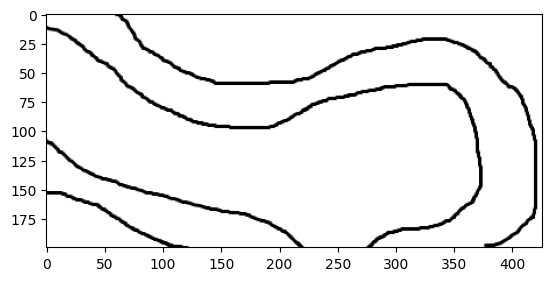

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import time as t
import numpy as np
import heapq
import yaml

virage = Image.open('virage3.png')
imgplot = plt.imshow(virage)

**2a - Transformation en Array Numpy**

(200, 426)


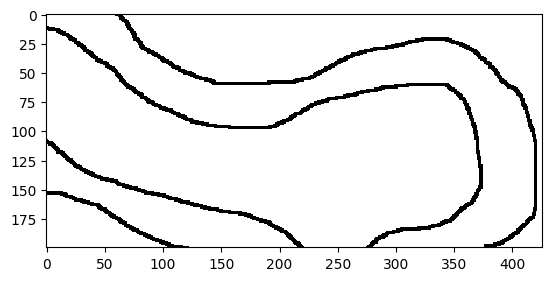

In [7]:
img = np.asarray(virage)
map = np.ones(img.shape[:2])
for i in range(len(map)) :
    for j in range(len(map[0])) :
        if img[i][j][0] == 255 :
            map[i][j] = 1 # case libre
        else :
            map[i][j] = 0 # mur
        
print(map.shape)

plt.imshow(map, cmap='gist_gray', interpolation='nearest')
plt.show()

**2b - On ajoute un espace de sécurité autour des bords du circuit**

In [8]:
def securite_map(map, resolution) :
    # Ajout d'une distance de securité autour des murs
    x_max, y_max = map.shape
    for i in range(len(map)) :
        for j in range(len(map[0])) :
            if map[i][j] == 0 :# Pour chaque pixel de mur
                # On ajoute une zone de sécurité
                mini_x = max(0, i - resolution)
                mini_y = max(0, j - resolution)
                maxi_x = min(x_max - 1, i + resolution)
                maxi_y = min(y_max - 1, j + resolution)
                for x in range(mini_x, maxi_x + 1) :
                    for y in range(mini_y, maxi_y + 1) :
                        if map[x][y] == 1 :
                            map[x][y] = 0.5
    return map

**3a - Algorithme A étoile**

In [9]:
def heuristique2(a, b):
    # Distance de Manhattan
    return np.abs(b[0] - a[0]) + np.abs(b[1] - a[1])

def heuristique1(a, b) :
    # Distance euclidienne
    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    

def astar(map, start, goal, vide):

    action = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)] # Liste des mouvements possibles
    close_set = set() # Ensemble des positions à ne plus considérer (déjà regardées)
    chemin_pos = {} # Ensemble des positions des parents de chaque position
    dist_orig = {start:0} # Score : Distance au point de départ
    score = {start:heuristique2(start, goal)} # Score : Distance au point de départ + Distance à l'arrivée estimée (via l'heuristique)
    pile_pos = [] # Pile des positions à considérer comme le plus court chemin
    
    # On push la position de départ et son score sur la pile
    heapq.heappush(pile_pos, (score[start], start))
 
    while pile_pos: # On check les positions à regarder tant qu'il y en a
        
        # On récupère la position du voisin avec le plus petit score possible
        current = heapq.heappop(pile_pos)[1]
        
        if current == goal: # Si on a atteint l'arrivée, on récupère le plus court chemin en remontant la liste des parents des positions considérées
            data = []
            while current in chemin_pos:
                data.append(current)
                current = chemin_pos[current]
            return data

        # Sinon, on met cette position dans la liste des positions à ne plus regarder
        close_set.add(current)

        for i, j in action: # Pour tous les voisins
            neighbor = current[0] + i, current[1] + j # On calcule sa position (pos actuel + mouvement)           
            tentative_g_score = dist_orig[current] + heuristique2(current, neighbor)

            if 0 <= neighbor[0] < map.shape[0]: # Si le voisin est en dehors de la grille (effet de bord), on ne le prend pas en compte
                if 0 <= neighbor[1] < map.shape[1]:                
                    if map[neighbor[0]][neighbor[1]] < vide:
                        continue # l'instruction continue permet de passer à l'itération suivante de la boucle for 
                else:
                    # limite en y (horizontal)(vertical)
                    continue
            else:
                # limite en x (vertical)
                continue
            
            if neighbor in close_set and tentative_g_score >= dist_orig.get(neighbor, 0):
                # Si le voisin a déjà été vu et que le score de la nouvelle position avec l'heuristique est moins bon que le score actuel
                continue
            
            if  tentative_g_score < dist_orig.get(neighbor, 0) or neighbor not in [i[1]for i in pile_pos]:
                # Meilleur score d'heuristique ou position non rencontrée : on l'ajoute à la pile des positions à considérer
                chemin_pos[neighbor] = current
                dist_orig[neighbor] = tentative_g_score
                score[neighbor] = tentative_g_score + heuristique2(neighbor, goal)
                heapq.heappush(pile_pos, (score[neighbor], neighbor)) 
                

**3b - Detection de frontières et choix du point objectif**

In [10]:
def distance(a, b, c, d) :
    # distance euclidienne entre (a,b) et (c,d)
    return np.sqrt((c - a)**2 + (d - b)**2 )

def detect_goal(map, start, vide):
    # Fonction qui détecte les frontières et indique ou aller à l'algorithme A*
    
    bordure_map = []
    x_max, y_max = map.shape
    bordure_map.append([[(0, j), map[0, j]] for j in range(len(map[0]))]) # haut
    bordure_map.append([[(x_max - 1, j), map[x_max - 1, j]] for j in range(len(map[0]))]) # bas
    bordure_map.append([[(i, 0), map[i, 0]] for i in range(len(map))]) # gauche
    bordure_map.append([[(i, y_max - 1), map[i, y_max - 1]] for i in range(len(map))]) # droite
    frontieres = [] # liste des frontières

    # Detection des frontières (par leurs points extrêmes)
    for bord in bordure_map :
        for i in range(len(bord)) :
            if bord[i][1] == vide and i == 0 : # début de frontière
                frontieres.append([bord[i][0]])
            elif bord[i][1] == vide and bord[i - 1][1] != vide : # début de frontière
                frontieres.append([bord[i][0]])
            if bord[i][1] == vide and i == len(bord) -1 : # fin de frontière
                frontieres[-1].append(bord[i][0])
            elif bord[i][1] == vide and bord[i + 1][1] != vide : # fin de frontière
                frontieres[-1].append(bord[i][0])
    
    dist = [] # distance aux frontières
    
    for front in frontieres :
        centre = ( 0.5 * (front[0][0] + front[1][0]), 0.5 * (front[0][1] + front[1][1]) )
        dist.append(distance(centre[0], centre[1], start[0], start[1]))
    
    ind_best_front = dist.index(max(dist)) # On veut la frontière la plus plus lointaine
    
    d1 = distance(frontieres[ind_best_front][0][0], frontieres[ind_best_front][0][1], start[0], start[1])
    d2 = distance(frontieres[ind_best_front][1][0], frontieres[ind_best_front][1][1], start[0], start[1])
    
    if d1 < d2 : # On retourne le point le plus proche de la frontière la plus lointaine
        return frontieres[ind_best_front][0]
    else :
        return frontieres[ind_best_front][1]
    
def detect_circuit(map, start, vide_avant, vide_apres) :
    """Fonction qui détecte les points accessibles et précise le meilleur point à atteindre pour A*.
    Map est la carte avec frontières plus larges (par sécurité)"""
    
    circuit = set() # Ensemble des points à traiter du circuit
    x_max = len(map) - 1
    y_max = len(map[0]) - 1
    map[start[0]][start[1]] = vide_apres # 2 = zone accessible
    action = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)] # Liste des mouvements possibles
    
    # On push la position de départ sur la pile
    circuit.add(start)
    
    while len(circuit) != 0  :
        # On récupère la position d'un élément de l'ensemble
        current = circuit.pop()
        for i, j in action : # Pour chaque voisin
            neighbor = current[0] + i, current[1] + j # On calcule sa position (pos actuel + mouvement) 
            if (neighbor[0] >= 0 and neighbor[0] <= x_max) and (neighbor[1] >= 0 and neighbor[1] <= y_max) :
                if map[neighbor[0]][neighbor[1]] == vide_avant :
                    map[neighbor[0]][neighbor[1]] = vide_apres
                    circuit.add(neighbor)
    return map    
    

**4 - Paramétrage et test**

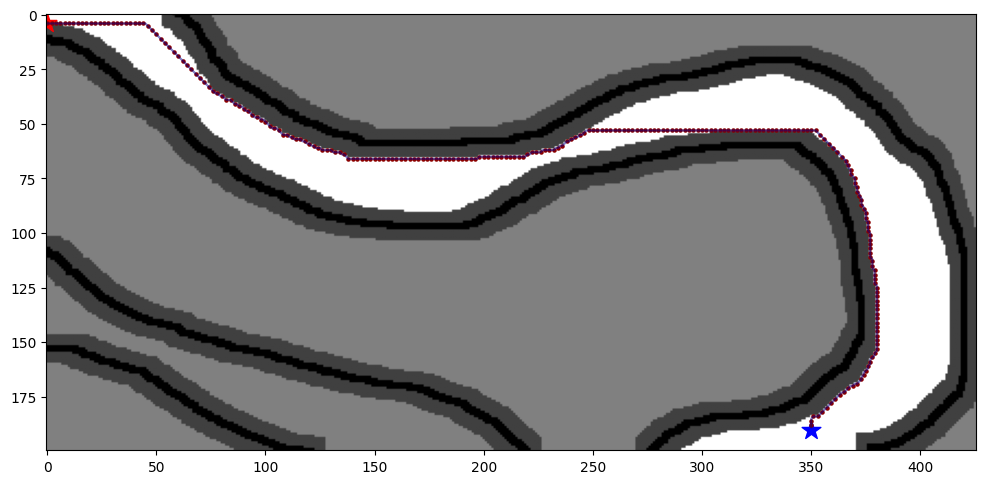

Temps de calcul global :  2.5006678104400635  s
Temps de calcul A* :  2.0893964767456055  s


In [12]:
# Création de la map
virage = Image.open('virage3.png') # Image simulant une map donnée par le lidar ou SLAM
img = np.asarray(virage)
map = np.ones(img.shape[:2])
for i in range(len(map)) :
    for j in range(len(map[0])) :
        if img[i][j][0] == 255 :
            map[i][j] = 1 # case libre
        else :
            map[i][j] = 0 # mur

t1 = t.time()
# Paramétrage initial ################################################################
start = (190, 350) # Point de départ
resolution = 5 # 10 pixels de sécurité
echelle_wp = int(resolution/2) # Waypoint tous les X pixels
vide = 2 # zone libre
trace = True # Tracé du résultat
map = securite_map(map, resolution) # Ajout des frontières de sécurité
map = detect_circuit(map, start, 1, vide) # Detection des zones accessibles
goal = detect_goal(map, start, vide) # Detection automatique du point à atteindre (x, y)
######################################################################################

# On lance l'algorithme A*
t2 = t.time()
route = astar(map, start, goal, vide)
t3 = t.time()
x_traj = []
y_traj = []
x_wp = [] # x waypoint
y_wp = [] # y waypoint

for i in (range(0,len(route))):
    x = route[i][0]
    x_traj.append(route[i][0])
    y_traj.append(route[i][1])
    if i%echelle_wp == 0:
        x_wp.append(route[i][0])
        y_wp.append(route[i][1])

t4 = t.time()

if trace :    
    # Tracé de la carte et de la trajectoire
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(map, cmap='gist_gray')
    ax.plot(y_traj,x_traj, color = "darkblue", alpha = 0.5)
    ax.scatter(start[1],start[0], marker = "*", color = "blue", s = 200)
    ax.scatter(goal[1],goal[0], marker = "*", color = "red", s = 200)
    ax.scatter(y_wp, x_wp, marker = ".", color = "darkred", s = 20)
    plt.savefig("exemple_circuit_partiel.png")

    plt.show()

print("Temps de calcul global : ", (t4 - t1), " s")
print("Temps de calcul A* : ", (t3 - t2), " s")

**5 - A etoile sur circuit complet**

In [13]:
def detect_end(map, start, mur, direction) :
    """Créé une frontière sur la map derrière la voiture et donne le but à atteindre"""
    x_voit, y_voit = start
    #-------> axe Y
    #|
    #|
    #v axe X
    ind1 = 1
    ind2 = 1
    if direction == 1 : # NORD --> frontière horizontale au sud de la voiture
        goal = (x_voit + 2, y_voit)
        map[x_voit + 1, y_voit] = mur
        while (ind1>= 0) or (ind2>=0) :
            if ind1 >= 0 :
                if map[x_voit + 1][y_voit + ind1] != mur :
                    map[x_voit + 1][y_voit + ind1] = mur
                    ind1 = ind1 + 1
                else :
                    ind1 = -1
            if ind2 >= 0 :
                if map[x_voit + 1][y_voit - ind2] != mur :
                    map[x_voit + 1][y_voit - ind2] = mur
                    ind2 = ind2 + 1
                else :
                    ind2 = -1
    elif direction == 2 : # EST --> frontière verticale à l'ouest de la voiture
        goal = (x_voit, y_voit - 2)
        map[x_voit, y_voit - 1] = mur
        while (ind1>= 0) or (ind2>=0) :
            if ind1 >= 0 :
                if map[x_voit + ind1][y_voit - 1] != mur :
                    map[x_voit + ind1][y_voit - 1] = mur
                    ind1 = ind1 + 1
                else :
                    ind1 = -1
            if ind2 >= 0 :
                if map[x_voit - ind2][y_voit - 1] != mur :
                    map[x_voit - ind2][y_voit - 1] = mur
                    ind2 = ind2 + 1
                else :
                    ind2 = -1
    elif direction == 3 : # SUD --> frontière horizontale au nord de la voiture
        goal = (x_voit - 2, y_voit)
        map[x_voit - 1, y_voit] = mur
        while (ind1>= 0) or (ind2>=0) :
            if ind1 >= 0 :
                if map[x_voit - 1][y_voit + ind1] != mur :
                    map[x_voit - 1][y_voit + ind1] = mur
                    ind1 = ind1 + 1
                else :
                    ind1 = -1
            if ind2 >= 0 :
                if map[x_voit - 1][y_voit - ind2] != mur :
                    map[x_voit - 1][y_voit - ind2] = mur
                    ind2 = ind2 + 1
                else :
                    ind2 = -1
    elif direction == 4 : # OUEST --> frontière verticale à l'est de la voiture
        goal = (x_voit, y_voit + 2)
        map[x_voit, y_voit + 1] = mur
        while (ind1>= 0) or (ind2>=0) :
            if ind1 >= 0 :
                if map[x_voit + ind1][y_voit + 1] != mur :
                    map[x_voit + ind1][y_voit + 1] = mur
                    ind1 = ind1 + 1
                else :
                    ind1 = -1
            if ind2 >= 0 :
                if map[x_voit - ind2][y_voit + 1] != mur :
                    map[x_voit - ind2][y_voit + 1] = mur
                    ind2 = ind2 + 1
                else :
                    ind2 = -1
    
    return map, goal
    

('0.058', ['-84.9', '-36.3', '0'])


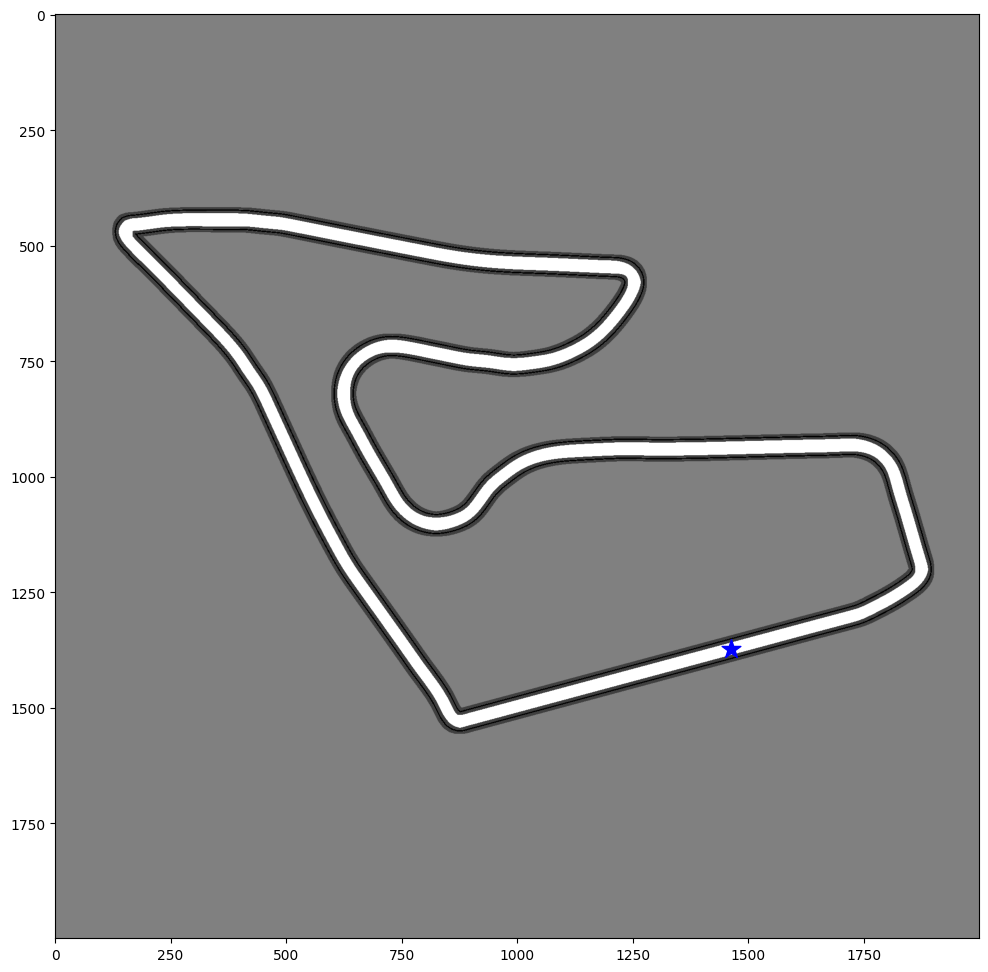

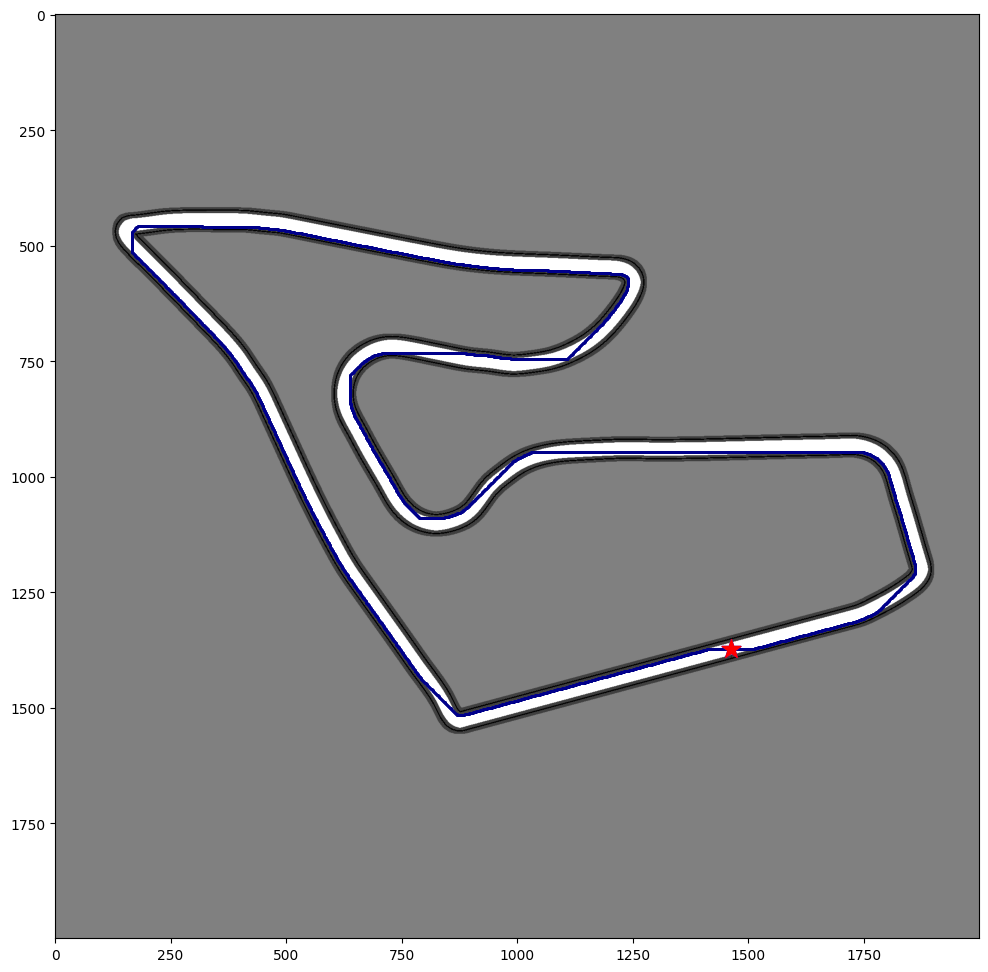

Temps de calcul global :  18.57086682319641  s
Temps de calcul A* :  12.791265726089478  s


In [14]:
# Création de la map
circuit = Image.open('example.pgm') # Image simulant une map complète donnée par le SLAM

img = np.asarray(circuit)
map = np.divide(img, 254)

t1 = t.time()

# Récupération des info de la map

def get_info_map(map_info):
    """Permet d'obtenir la résolution et l'origine de la carte"""
    with open(map_info) as f:
        data = yaml.load(f, Loader = yaml.loader.BaseLoader)
        return((data["resolution"], data["origin"]))

info = get_info_map("map.yaml")
print(info)

# Paramétrage initial ################################################################
start = (1374, 1464) # Point de départ
resolution = 5 # 10 pixels de sécurité
echelle_wp = int(resolution/2) # Waypoint tous les X pixels
vide = 2 # zone libre
mur = 0 # zone occupée
direction = 2 # 1 = Nord, 2 = Est, 3 = Sud, 4 = Ouest
trace = True # Tracé du résultat
map = securite_map(map, resolution) # Ajout des frontières de sécurité
map = detect_circuit(map, start, 1, vide) # Detection des zones accessibles

# Tracé de la carte et de la trajectoire
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(map, cmap='gist_gray')
ax.scatter(start[1],start[0], marker = "*", color = "blue", s = 200)
#ax.scatter(y_wp, x_wp, marker = ".", color = "darkred", s = 20)
map, goal = detect_end(map, start, mur, direction) # Detection automatique du point à atteindre (x, y)
######################################################################################

# On lance l'algorithme A*
t2 = t.time()
route = astar(map, start, goal, vide)
t3 = t.time()
x_traj = []
y_traj = []
x_wp = [] # x waypoint
y_wp = [] # y waypoint

for i in (range(0,len(route))):
    x = route[i][0]
    x_traj.append(route[i][0])
    y_traj.append(route[i][1])
    if i%echelle_wp == 0:
        x_wp.append(route[i][0])
        y_wp.append(route[i][1])

t4 = t.time()

if trace :    
    # Tracé de la carte et de la trajectoire
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(map, cmap='gist_gray')
    ax.scatter(y_traj,x_traj, marker = ".", color = "darkblue", s = 5)
    ax.scatter(start[1],start[0], marker = "*", color = "blue", s = 200)
    ax.scatter(goal[1],goal[0], marker = "*", color = "red", s = 200)
    #ax.scatter(y_wp, x_wp, marker = ".", color = "darkred", s = 20)
    plt.savefig("visualisation.png", dpi = 800)

    plt.show()


print("Temps de calcul global : ", (t4 - t1), " s")
print("Temps de calcul A* : ", (t3 - t2), " s")
